In [7]:
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets import CNNIberFireDataset
from torch.utils.data import DataLoader

ZARR_PATH = project_root / "data" / "silver" / "IberFire.zarr"

In [19]:
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

feature_vars = [
    "wind_speed_mean",
    "t2m_mean",
    "RH_mean",
    "total_precipitation_mean",
]
in_channels = len(feature_vars)

train_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2018-01-01",
    time_end="2020-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=1,         # predict tomorrow
    compute_stats=True,  # or precompute & pass stats
)

train_loader = DataLoader(
    train_ds,
    batch_size=4,        # start small, check memory
    shuffle=True,
    num_workers=4,
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2018-01-01 to 2020-12-31
[SimpleDataset] Total usable time steps: 1096
[SimpleDataset] Computing normalization stats from data...
[SimpleDataset] wind_speed_mean: mean=2.4198, std=1.1674
[SimpleDataset] t2m_mean: mean=14.4443, std=7.4886
[SimpleDataset] RH_mean: mean=68.8383, std=16.8957
[SimpleDataset] total_precipitation_mean: mean=0.9676, std=2.5863


In [20]:
X, y = train_ds[0]
print(f"Feature tensor shape: {X.shape}, Label tensor shape: {y.shape}")
print(train_ds.get_time_value(0))


Feature tensor shape: torch.Size([4, 230, 297]), Label tensor shape: torch.Size([1, 230, 297])
2018-01-01T00:00:00.000000000


In [33]:
model = smp.Unet(
    encoder_name="resnet34",      # or "timm-efficientnet-b0", etc.
    encoder_weights="imagenet",          # or None if you don't want pretrained
    in_channels=in_channels,               # IberFire: number of feature channels per pixel
    classes=1,                    # 1 output channel for fire / no-fire probability
    activation=None               # we'll apply sigmoid later in the loss/metrics
)

# Example forward
# x: (batch_size, 64, H, W) -> logits: (batch_size, 1, H, W)

In [24]:
# sanity check
X, y = train_ds[0]                      # X: [C, H, W], y: [1, H, W]
X = X.unsqueeze(0)                      # [1, C, H, W]
with torch.no_grad():
    out = model(X)

print("Input :", X.shape)               # [1, 4, H, W]
print("Target:", y.unsqueeze(0).shape)  # [1, 1, H, W]
print("Output:", out.shape)            # should be [1, 1, H, W]

Input : torch.Size([1, 4, 230, 297])
Target: torch.Size([1, 1, 230, 297])
Output: torch.Size([1, 1, 230, 297])


In [11]:
# test dataset
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2021-01-01",
    time_end="2021-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=1,
    compute_stats=True,
)
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2021-01-01 to 2021-12-31
[SimpleDataset] Total usable time steps: 365
[SimpleDataset] Computing normalization stats from data...
[SimpleDataset] wind_speed_mean: mean=2.4186, std=1.1589
[SimpleDataset] t2m_mean: mean=14.0974, std=7.1943
[SimpleDataset] RH_mean: mean=68.3215, std=16.0762
[SimpleDataset] total_precipitation_mean: mean=1.0134, std=2.3897


In [12]:
import tqdm

In [34]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device)
#criterion = FocalLoss(mode="binary")
pos_weight = torch.tensor([10.0], device=device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Using device: mps


In [32]:
# model = torch.compile(model, mode="max-autotune-no-cudagraphs")

In [28]:
num_epochs = 10

In [35]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols = 100)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

        pbar.set_postfix({"loss": loss.item()})

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

Epoch 1/10: 100%|█████████████████████████████████████| 548/548 [15:35<00:00,  1.71s/it, loss=0.245]


Epoch 1/10, Training Loss: 0.3919


Epoch 2/10: 100%|█████████████████████████████████████| 548/548 [10:00<00:00,  1.10s/it, loss=0.231]


Epoch 2/10, Training Loss: 0.2784


Epoch 3/10: 100%|█████████████████████████████████████| 548/548 [10:08<00:00,  1.11s/it, loss=0.125]


Epoch 3/10, Training Loss: 0.2600


Epoch 4/10: 100%|█████████████████████████████████████| 548/548 [10:53<00:00,  1.19s/it, loss=0.455]


Epoch 4/10, Training Loss: 0.2526


Epoch 5/10: 100%|█████████████████████████████████████| 548/548 [10:16<00:00,  1.13s/it, loss=0.468]


Epoch 5/10, Training Loss: 0.2488


Epoch 6/10: 100%|█████████████████████████████████████| 548/548 [10:21<00:00,  1.13s/it, loss=0.523]


Epoch 6/10, Training Loss: 0.2461


Epoch 7/10: 100%|█████████████████████████████████████| 548/548 [10:24<00:00,  1.14s/it, loss=0.209]


Epoch 7/10, Training Loss: 0.2442


Epoch 8/10: 100%|█████████████████████████████████████| 548/548 [11:54<00:00,  1.30s/it, loss=0.298]


Epoch 8/10, Training Loss: 0.2435


Epoch 9/10: 100%|█████████████████████████████████████| 548/548 [19:17<00:00,  2.11s/it, loss=0.176]


Epoch 9/10, Training Loss: 0.2420


Epoch 10/10: 100%|████████████████████████████████████| 548/548 [18:05<00:00,  1.98s/it, loss=0.297]

Epoch 10/10, Training Loss: 0.2411


In [38]:
# save model 
import os
model_path = project_root / "models" / "unet_iberfire.pth"
os.makedirs(model_path.parent, exist_ok=True)
torch.save(model.state_dict(), model_path)

# Load model

In [2]:
# load model
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets import CNNIberFireDataset
from torch.utils.data import DataLoader

ZARR_PATH = project_root / "data" / "silver" / "IberFire.zarr"
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

feature_vars = [
    "wind_speed_mean",
    "t2m_mean",
    "RH_mean",
    "total_precipitation_mean",
]
in_channels = len(feature_vars)

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets import CNNIberFireDataset
from torch.utils.data import DataLoader

project_root = Path.cwd().parent
model_path = project_root / "models" / "unet_iberfire.pth"
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=in_channels,
    classes=1,
    activation=None,
)
device = "mps"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [3]:
model = model.to(device)

In [4]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
# test dataset
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2021-01-01",
    time_end="2021-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=1,
    compute_stats=True,
)
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2021-01-01 to 2021-12-31
[SimpleDataset] Total usable time steps: 365
[SimpleDataset] Computing normalization stats from data...
[SimpleDataset] wind_speed_mean: mean=2.4157, std=1.1499
[SimpleDataset] t2m_mean: mean=14.0658, std=7.1285
[SimpleDataset] RH_mean: mean=67.9062, std=15.8625
[SimpleDataset] total_precipitation_mean: mean=0.9289, std=2.5029


In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compare_prediction(date_str: str):
    """
    Show model prediction for a given date with ground-truth fire mask overlaid.
    Prediction: blue-red heatmap, Label: transparent red mask.
    """
    # 1) Find index for the requested date
    idx = None
    for i in range(len(test_ds)):
        t = test_ds.get_time_value(i)  # assumes np.datetime64 or similar
        if str(t)[:10] == date_str:
            idx = i
            break

    if idx is None:
        print(f"No sample found for date {date_str}")
        return

    print(f"Using sample index {idx} for date {date_str}")

    # 2) Get data and run model
    X, y = test_ds[idx]            # X: [C,H,W], y: [1,H,W]
    X_batch = X.unsqueeze(0).to(device).float()

    model.eval()
    with torch.no_grad():
        logits = model(X_batch)    # [1,1,H,W]
        probs = torch.sigmoid(logits).cpu().squeeze().numpy()  # [H,W]

    target = y.squeeze().numpy()   # [H,W], 0/1

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Base: prediction heatmap (blue-red)
    im_pred = ax.imshow(
        probs,
        cmap="bwr",
        vmin=0.0,
        vmax=1.0,
        origin="lower",
    )
    plt.colorbar(im_pred, ax=ax, fraction=0.046, pad=0.04, label="Predicted prob")

    # Overlay: ground-truth mask as transparent red
    # ensure mask is 0/1
    mask = (target > 0.5).astype(float)
    # use alpha mask so only fire pixels are visible
    im_gt = ax.imshow(
        np.ma.masked_where(mask == 0, mask),
        cmap="Reds",
        vmin=0.0,
        vmax=1.0,
        origin="lower",
        alpha=0.6,   # transparency of label overlay
    )

    ax.set_title(f"Predicted wildfire probability heatmap VS. real fires (squares)\n for Spain on {date_str}")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

Using sample index 214 for date 2021-08-03


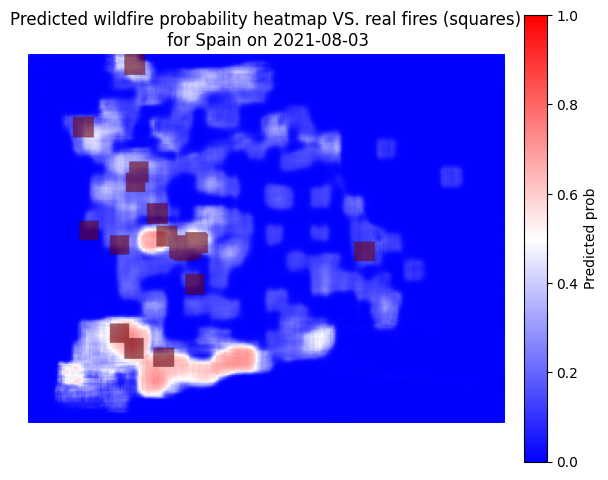

In [20]:
compare_prediction("2021-08-03")